In [1]:
# Support for math
import numpy as np
import math

# Plotting tools
from matplotlib import pyplot as plt
import matplotlib
from matplotlib import cm
import plotly.graph_objects as go
from plotly.subplots import make_subplots

import warnings
warnings.filterwarnings('ignore')

# File Tools for local
import pandas as pd
import sys

# Random seed for reproducibility
import random

import torch
from botorch.utils.transforms import unnormalize, normalize

from ipywidgets import interact, FloatSlider

#LHS sampling
#from pyDOE import lhs

from BOClass import Models, Plotting, PoolObjectives
#from BOClass_querybased import Models, Plotting, PoolObjectives

dtype = torch.float32
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
all_data = pd.read_csv('all_data.csv') # all_df = pd.concat([data01, data2A, data2B, data2C, data3A, data3B, data3C], axis=0, ignore_index=True)
data01 = all_data[:15]
data2A = all_data[15:30]
data2B = all_data[30:45]
data2C = all_data[45:60]
data3A = all_data[60:75]
data3B = all_data[75:90]
data3C = all_data[90:105]
# Model Sets
set_dataA = pd.concat([data01, data2A, data3A], axis=0, ignore_index=True)
set_dataB = pd.concat([data01, data2B, data3B], axis=0,ignore_index=True)
set_dataC = pd.concat([data01, data2C, data3C], axis=0,ignore_index=True)


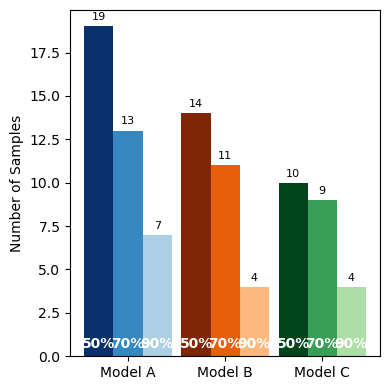

In [3]:
# Check Data
thresholds = [0.5, 0.7, 0.9]

# Calculate counts for each threshold for each model
counts_A = [ (set_dataA['yield product'] > thresh).sum().item() for thresh in thresholds ]
counts_B = [ (set_dataB['yield product'] > thresh).sum().item() for thresh in thresholds ]
counts_C = [ (set_dataC['yield product'] > thresh).sum().item() for thresh in thresholds ]

model_counts = [counts_A, counts_B, counts_C]
model_names = ['ModelA', 'ModelB', 'ModelC']  # Used for cm.*
num_bars_per_model = len(thresholds)

# Bar settings
bar_width = 0.3
x = np.arange(len(model_names))

# Colormap mapping
cmap_dict = {'ModelA': cm.Blues, 'ModelB': cm.Oranges, 'ModelC': cm.Greens}

# Create plot
fig, ax = plt.subplots(figsize=(4, 4))

# Plot each model group
for i, (model, counts) in enumerate(zip(model_names, model_counts)):
    cmap = cmap_dict[model]
    # Light to dark (0 = light, 1 = dark); reversed here for higher threshold to be lighter
    gradient_colors = [cmap(1 - j / num_bars_per_model) for j in range(num_bars_per_model)]
    
    for j, count in enumerate(counts):
        # j = threshold index (0: 0.5, 1: 0.7, 2: 0.9)
        xpos = x[i] + j * bar_width - bar_width  # Center group around x[i]
        rect = ax.bar(xpos, count, width=bar_width, color=gradient_colors[j],
                      label=f'{model} - {thresholds[j]:.1f}' if i == 0 else None)  # Only label once per threshold
        ax.bar_label(rect, padding=3, fontsize=8)

# Ticks and labels
ax.set_xticks(x)
ax.set_xticklabels(['Model A', 'Model B', 'Model C'])
ax.set_ylabel('Number of Samples')

# Add annotations for thresholds
for i, model in enumerate(model_names):
    for j, count in enumerate(model_counts[i]):
        xpos = x[i] + j * bar_width - bar_width  # Center group around x[i]
        ax.text(xpos, 0.3, f'{thresholds[j]*100:.0f}%', ha='center', va='bottom', fontsize=10, fontweight = 'bold',color='white')

plt.tight_layout()
plt.show()


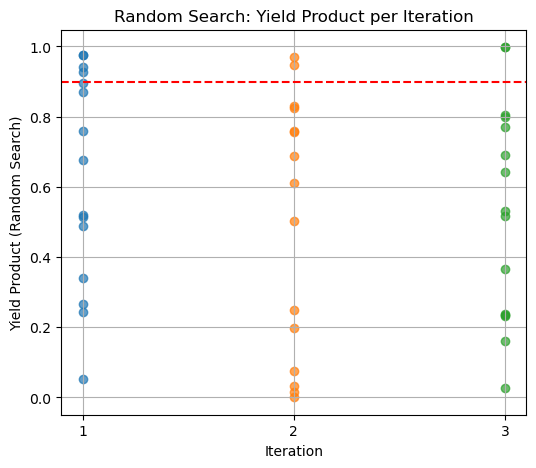

In [57]:
# This random sampling is accurate since it chooses 3 temperatures. 
# However, it depends whether the pool has enough samples with the same temperatures.
# So it can fail if the pool does not have enough samples with the same temperatures. 
random_seed = 7
iterations = 3
batch_size = 15
num_samples = batch_size * iterations

# Assume your data has a 'temp' column for temperature and 'yield product' column
all_data = all_data.sample(frac=1, random_state=random_seed)  # shuffle data once

iteration = np.arange(1, iterations + 1)
random_sampling = []

np.random.seed(random_seed)

for i in range(iterations):
    # Randomly select 3 unique temperatures from the pool
    available_temps = all_data['temp'].unique()
    selected_temps = np.random.choice(available_temps, size=3, replace=False)
    
    # Filter data for only these temperatures
    temp_filtered_data = all_data[all_data['temp'].isin(selected_temps)]
    
    # Sample 15 points from the filtered data
    batch_samples = temp_filtered_data.sample(n=batch_size, random_state=random_seed + i)
    
    random_sampling.append(batch_samples['yield product'])

# Plotting
plt.figure(figsize=(6, 5))
for i, samples in enumerate(random_sampling):
    plt.scatter([iteration[i]] * len(samples), samples.values, alpha=0.7)
plt.xlabel('Iteration')
plt.axhline(y=0.9, color='red', linestyle='--', label='y=0.9')
plt.ylabel('Yield Product (Random Search)')
plt.title('Random Search: Yield Product per Iteration')
plt.grid(True)
plt.xticks(range(1, iterations + 1))
plt.show()



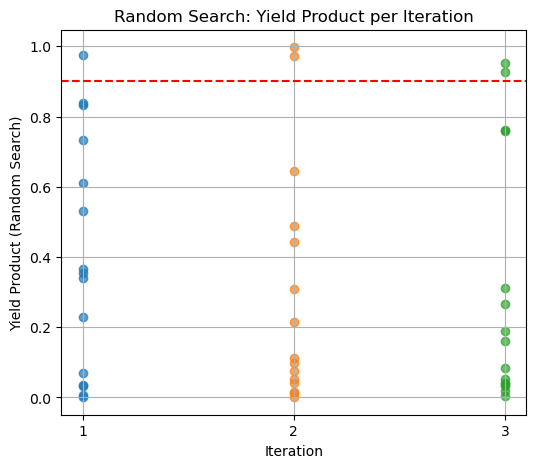

In [33]:
random_seed = 10
iterations = 3
# Perform a random search on set_dataA for 5 random samples

iteration = np.arange(1, iterations+1)

batch_size = 15
num_samples = batch_size * iterations
random_samples = all_data.sample(n=num_samples, random_state=random_seed)
random_sampling = [random_samples.iloc[i*batch_size:(i+1)*batch_size]['yield product'] for i in range(iterations)]


plt.figure(figsize=(6, 5))
for i, samples in enumerate(random_sampling):
    plt.scatter([iteration[i]] * len(samples), samples.values, alpha=0.7)
plt.xlabel('Iteration')
plt.axhline(y=0.9, color='red', linestyle='--', label='y=0.9')
plt.ylabel('Yield Product (Random Search)')
plt.title('Random Search: Yield Product per Iteration')
plt.grid(True)
plt.xticks(range(1, iterations + 1))
plt.show()


In [6]:
original_bounds = torch.tensor([[30., 20., 75. , 33.], [600., 170., 100.,100.]], dtype=dtype, device=device)
random.seed(5)

x_inputs = all_data[['time','temp','sulf','anly'] ]
y_outputs = all_data["yield product"]
yvar_outputs = all_data["var yield"]
# Set the device and dtype
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype = torch.float32
# Convert to torch tensors
x_all = torch.tensor(x_inputs.to_numpy(), dtype=torch.float32)
nx_all = normalize(x_all,original_bounds)
y_all = torch.tensor(y_outputs.values.reshape(-1, 1), dtype=torch.float32)
yvar_all = torch.tensor(yvar_outputs.values.reshape(-1, 1), dtype=torch.float32)


random_indices = random.sample(range(x_all.shape[0]), 5)
x_train = x_all[random_indices]
nx_train = normalize(x_train, bounds=original_bounds) # normalized data for training

y_train = y_all[random_indices]
y_train_var = yvar_all[random_indices]

query = PoolObjectives(x_inputs, y_outputs,yvar_outputs)

# Step 1: Initialize your model
gp_model = Models(x_train=nx_train, y_train=y_train, y_train_var=y_train_var, bounds=original_bounds, batch_size=10, objective=query)

# Step 2: Initialize Plotting class
variable_combinations = [('time', 'sulf', 'anly'), ('time', 'anly', 'sulf'), ('sulf', 'anly', 'time')]
plotting = Plotting(gp_model, variable_combinations=variable_combinations)

combination = variable_combinations[0]

minmax = [y_train.min(), y_train.max()]
#plotting.sliced_plotting('ModelA',combination, minmax)

In [7]:
def BO_loop_ModelA(gp_model,train_nx, train_y,train_yvar, x_all, y_all, yvar_all,iterations=5):
    query = PoolObjectives(x_all, y_all,yvar_all)
    for i in range(iterations):
        # Step 3: Get the next candidates
        new_candidates = gp_model.ModelA_candidates(feature='temp')
        candidate_id = gp_model.get_top_indices().tolist()
        print(new_candidates)
        # Remove new_candidates from x_all
        x_candidates = torch.tensor(new_candidates[['time', 'temp', 'sulf', 'anly']].to_numpy(), dtype=dtype, device=device)
        y_out = torch.tensor(new_candidates['yield product'].to_numpy().reshape(-1, 1), dtype=dtype, device=device)
        yvar_out = torch.tensor(new_candidates['var yield'].to_numpy().reshape(-1, 1), dtype=dtype, device=device)
        
        # Update the query with the new candidates
        x_inputs, y_outputs, yvar_outputs = query.remove_duplicates(candidate_id)
        query = PoolObjectives(x_inputs, y_outputs, yvar_outputs)

        nx_train = normalize(x_candidates, bounds=original_bounds)
        #print(x_train.shape, y_train.shape, yvar_train.shape)
        # Combine the new data with the existing data
        train_nx = torch.cat((train_nx, nx_train), dim=0)
        train_y = torch.cat((train_y, y_out), dim=0)
        train_yvar = torch.cat((train_yvar, yvar_out), dim=0)
        #print(train_nx.shape, train_y.shape, train_yvar.shape)
        # Step 1: Instantiate and train model
        gp_model = Models(x_train=train_nx, y_train=train_y, y_train_var=train_yvar, bounds=original_bounds, batch_size=1, objective=query)

    return gp_model, train_nx, train_y, train_yvar


tensor([0, 1, 2, 3, 4, 5])
    time    temp  sulf  anly  yield product  var yield  cluster
0  503.0  116.33  81.0  48.0           0.01       0.00        1
1  206.0  133.00  95.0  49.0           0.93       0.04        2
2  181.0   89.00  98.0  43.0           0.18       0.01        0
3  148.0  116.33  82.0  90.0           0.05       0.01        1
4  429.0  116.33  99.0  35.0           0.82       0.09        1
5  372.0  133.00  96.0  41.0           0.97       0.00        2
tensor([0, 1, 2, 3, 4, 5])
    time    temp  sulf  anly  yield product  var yield  cluster
0  503.0  116.33  81.0  48.0           0.01       0.00        1
1  206.0  133.00  95.0  49.0           0.93       0.04        2
2  181.0   89.00  98.0  43.0           0.18       0.01        0
3  148.0  116.33  82.0  90.0           0.05       0.01        1
4  429.0  116.33  99.0  35.0           0.82       0.09        1
5  372.0  133.00  96.0  41.0           0.97       0.00        2
tensor([0, 1, 2, 3, 4, 5])
    time    temp  sulf 

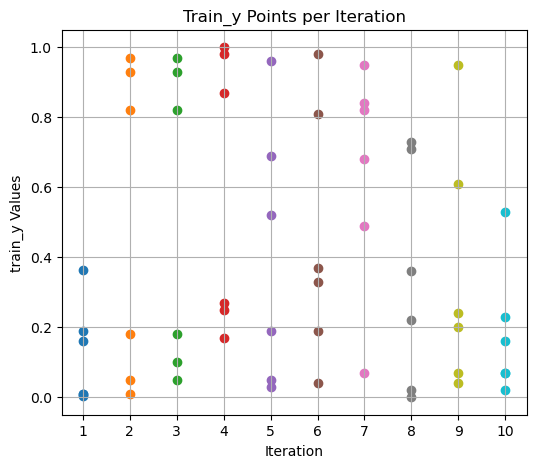

Iteration 1: tensor([471., 104.,  79.,  75.])
Iteration 2: tensor([372., 133.,  96.,  41.])
Iteration 3: tensor([372., 133.,  96.,  41.])
Iteration 4: tensor([391., 139.,  97.,  35.])
Iteration 5: tensor([556., 139.,  89.,  46.])
Iteration 6: tensor([350., 138.,  97.,  68.])
Iteration 7: tensor([600.0000, 138.7500,  93.0000,  56.0000])
Iteration 8: tensor([476., 138.,  91.,  56.])
Iteration 9: tensor([430., 139.,  95.,  87.])
Iteration 10: tensor([468.0000,  96.5000,  85.0000,  54.0000])


In [8]:
iterations = 10
gp_modeA, train_nA, train_yA, train_yvaA = BO_loop_ModelA(gp_model, nx_train, y_train, y_train_var, x_inputs, y_outputs, yvar_outputs, iterations = iterations)

train_xA = unnormalize(train_nA, original_bounds)
# Step 2: Initialize Plotting class
variable_combinations = [('time', 'sulf', 'anly'), ('theta', 'r', 't'), ('n', 't', 'theta')]
plotting = Plotting(gp_modeA, variable_combinations=variable_combinations)

combination = variable_combinations[0]

minmax = [y_train.min(), y_train.max()]
# plotting.sliced_plotting('ModelA',combination, minmax)

# Split train_y intoA iterations, each containingA points

points_per_iteration = 6
split_data = [train_yA[i * points_per_iteration:(i + 1) * points_per_iteration] for i in range(iterations)]
split_datax = [train_xA[i * points_per_iteration:(i + 1) * points_per_iteration] for i in range(iterations)]

# Plot the points vertically
plt.figure(figsize=(6, 5))
for i, data in enumerate(split_data):
    plt.scatter([i + 1] * len(data), data.numpy(), label=f'Iteration {i + 1}')

plt.xlabel('Iteration')
plt.ylabel('train_y Values')
plt.title('Train_y Points per Iteration')
plt.xticks(range(1, iterations + 1))
# plt.legend()
plt.grid(True)
plt.show()
argmax_indices = [data.argmax().item() for data in split_data]
for i, idx in enumerate(argmax_indices):
    print(f"Iteration {i + 1}: {split_datax[i][idx]}")

In [9]:
def BO_loop_ModelB(gp_model,train_nx, train_y,train_yvar, x_all, y_all, yvar_all,iterations=5):
    query = PoolObjectives(x_all, y_all,yvar_all)
    for i in range(iterations):
        # Step 3: Get the next candidates
        new_candidates = gp_model.ModelB_candidates(feature='temp')
        candidate_id = gp_model.get_top_indices().tolist()
        print(new_candidates)
        # Remove new_candidates from x_all
        x_candidates = torch.tensor(new_candidates[['time', 'temp', 'sulf', 'anly']].to_numpy(), dtype=dtype, device=device)
        y_out = torch.tensor(new_candidates['yield product'].to_numpy().reshape(-1, 1), dtype=dtype, device=device)
        yvar_out = torch.tensor(new_candidates['var yield'].to_numpy().reshape(-1, 1), dtype=dtype, device=device)
        
        # Update the query with the new candidates
        x_inputs, y_outputs, yvar_outputs = query.remove_duplicates(candidate_id)
        query = PoolObjectives(x_inputs, y_outputs, yvar_outputs)

        nx_train = normalize(x_candidates, bounds=original_bounds)
        #print(x_train.shape, y_train.shape, yvar_train.shape)
        # Combine the new data with the existing data
        train_nx = torch.cat((train_nx, nx_train), dim=0)
        train_y = torch.cat((train_y, y_out), dim=0)
        train_yvar = torch.cat((train_yvar, yvar_out), dim=0)
        #print(train_nx.shape, train_y.shape, train_yvar.shape)
        # Step 1: Instantiate and train model
        gp_model = Models(x_train=train_nx, y_train=train_y, y_train_var=train_yvar, bounds=original_bounds, batch_size=10, objective=query)

    return gp_model, train_nx, train_y, train_yvar


tensor([0, 1, 2, 3, 4, 5])
centroids: [[ 89.        ]
 [116.33333333]
 [133.        ]]
tensor([ 5,  1, 35, 71, 23, 12])
    time   temp  sulf  anly  yield product  var yield
0  372.0  133.0  96.0  41.0           0.97       0.00
1  206.0  133.0  95.0  49.0           0.93       0.04
2  274.0  133.0  75.0  52.0           0.24       0.11
3  101.0  133.0  85.0  98.0           0.52       0.04
4  268.0  133.0  83.0  74.0           0.68       0.14
5  517.0  133.0  77.0  79.0           0.27       0.02
tensor([0, 1, 2, 3, 4, 5])
centroids: [[120.5]
 [ 62. ]
 [ 89. ]]
tensor([ 4,  3, 98, 97, 96, 49])
    time   temp  sulf  anly  yield product  var yield
0  372.0  133.0  96.0  41.0           0.97       0.00
1  429.0  119.0  99.0  35.0           0.82       0.09
2  391.0  145.0  97.0  35.0           1.00       0.00
3  471.0  139.0  75.0  98.0           0.05       0.01
4  153.0  104.0  75.0  57.0           0.52       0.34
5  492.0  106.0  80.0  65.0           0.43       0.07
tensor([0, 1, 2, 3, 4, 5]

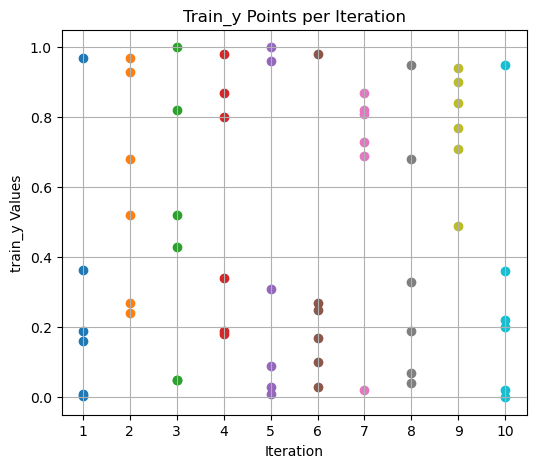

Iteration 1: tensor([372., 133.,  96.,  41.])
Iteration 2: tensor([372., 133.,  96.,  41.])
Iteration 3: tensor([391., 145.,  97.,  35.])
Iteration 4: tensor([545., 133.,  96.,  82.])
Iteration 5: tensor([353., 145.,  94.,  66.])
Iteration 6: tensor([350., 139.,  97.,  68.])
Iteration 7: tensor([261., 138.,  96.,  90.])
Iteration 8: tensor([600., 137.,  93.,  56.])
Iteration 9: tensor([561., 133.,  87.,  67.])
Iteration 10: tensor([430., 139.,  95.,  87.])


In [10]:
# Split train_y into B iterations, each containing B points
iterations = 10

gp_modelB, train_nxB, train_yB, train_yvarB = BO_loop_ModelB(gp_model, nx_train, y_train, y_train_var, x_inputs, y_outputs, yvar_outputs, iterations=iterations )

train_xB = unnormalize(train_nxB, original_bounds)
# Step 2: Initialize Plotting class
variable_combinations = [('time', 'sulf', 'anly'), ('theta', 'r', 't'), ('n', 't', 'theta')]
plotting = Plotting(gp_modelB, variable_combinations=variable_combinations)

combination = variable_combinations[0]

minmax = [y_train.min(), y_train.max()]
# plotting.sliced_plotting('ModelB',combination, minmax)


points_per_iteration = 6
split_data = [train_yB[i * points_per_iteration:(i + 1) * points_per_iteration] for i in range(iterations)]
split_datax = [train_xB[i * points_per_iteration:(i + 1) * points_per_iteration] for i in range(iterations)]

# Plot the points vertically
plt.figure(figsize=(6, 5))
for i, data in enumerate(split_data):
    plt.scatter([i + 1] * len(data), data.numpy(), label=f'Iteration {i + 1}')

plt.xlabel('Iteration')
plt.ylabel('train_y Values')
plt.title('Train_y Points per Iteration')
plt.xticks(range(1, iterations + 1))
# plt.legend()
plt.grid(True)
plt.show()
argmax_indices = [data.argmax().item() for data in split_data]
for i, idx in enumerate(argmax_indices):
    print(f"Iteration {i + 1}: {split_datax[i][idx]}")

In [11]:
def BO_loop_ModelC(gp_model,train_nx, train_y,train_yvar, x_all, y_all, yvar_all,iterations=5):
    query = PoolObjectives(x_all, y_all,yvar_all)
    for i in range(iterations):
        # Step 3: Get the next candidates
        new_candidates = gp_model.ModelC_candidates(feature='temp')
        candidate_id = gp_model.get_top_indices().tolist()
        print(new_candidates)
        # Remove new_candidates from x_all
        x_candidates = torch.tensor(new_candidates[['time', 'temp', 'sulf', 'anly']].to_numpy(), dtype=dtype, device=device)
        y_out = torch.tensor(new_candidates['yield product'].to_numpy().reshape(-1, 1), dtype=dtype, device=device)
        yvar_out = torch.tensor(new_candidates['var yield'].to_numpy().reshape(-1, 1), dtype=dtype, device=device)
        
        # Update the query with the new candidates
        x_inputs, y_outputs, yvar_outputs = query.remove_duplicates(candidate_id)
        query = PoolObjectives(x_inputs, y_outputs, yvar_outputs)

        nx_train = normalize(x_candidates, bounds=original_bounds)
        #print(x_train.shape, y_train.shape, yvar_train.shape)
        # Combine the new data with the existing data
        train_nx = torch.cat((train_nx, nx_train), dim=0)
        train_y = torch.cat((train_y, y_out), dim=0)
        train_yvar = torch.cat((train_yvar, yvar_out), dim=0)
        #print(train_nx.shape, train_y.shape, train_yvar.shape)
        # Step 1: Instantiate and train model
        gp_model = Models(x_train=train_nx, y_train=train_y, y_train_var=train_yvar, bounds=original_bounds, batch_size=10, objective=query)

    return gp_model, train_nx, train_y, train_yvar


tensor([0, 1, 2])
Constraints: [119. 133.  89.]
    time   temp  sulf  anly  yield product  var yield
0  206.0  133.0  95.0  49.0           0.93       0.04
1  268.0  133.0  83.0  74.0           0.68       0.14
2  274.0  133.0  75.0  52.0           0.24       0.11
3  517.0  133.0  77.0  79.0           0.27       0.02
4  556.0  133.0  89.0  46.0           0.96       0.00
5  372.0  133.0  96.0  41.0           0.97       0.00
tensor([98, 97, 96])
Constraints: [145. 104. 119.]
    time   temp  sulf  anly  yield product  var yield
0  201.0  145.0  75.0  79.0           0.03       0.01
1  543.0  145.0  79.0  88.0           0.21       0.11
2  353.0  145.0  94.0  66.0           1.00       0.00
3  163.0  145.0  90.0  57.0           0.80       0.15
4  372.0  133.0  96.0  41.0           0.97       0.00
5  530.0   62.0  89.0  51.0           0.10       0.03
tensor([0, 1, 2])
Constraints: [119.  89. 111.]
    time   temp  sulf  anly  yield product  var yield
0  503.0  119.0  81.0  48.0           0.01 

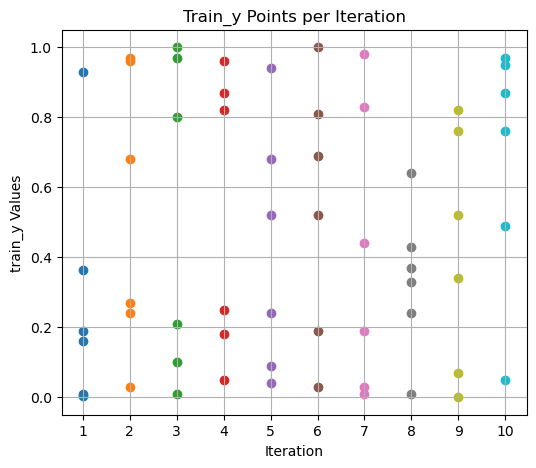

Iteration 1: tensor([206., 133.,  95.,  49.])
Iteration 2: tensor([372., 133.,  96.,  41.])
Iteration 3: tensor([353., 145.,  94.,  66.])
Iteration 4: tensor([556., 133.,  89.,  46.])
Iteration 5: tensor([561., 133.,  87.,  67.])
Iteration 6: tensor([391., 145.,  97.,  35.])
Iteration 7: tensor([350., 139.,  97.,  68.])
Iteration 8: tensor([260., 104.,  80.,  38.])
Iteration 9: tensor([423., 137.,  94.,  58.])
Iteration 10: tensor([569., 137.,  99.,  65.])


In [12]:
# Split train_y into B iterations, each containing B points
iterations = 10

gp_modelC, train_nxC, train_yC, train_yvarC = BO_loop_ModelC(gp_model, nx_train, y_train, y_train_var, x_inputs, y_outputs, yvar_outputs, iterations=iterations )

train_xC = unnormalize(train_nxC, original_bounds)
# Step 2: Initialize Plotting class
variable_combinations = [('time', 'sulf', 'anly'), ('theta', 'r', 't'), ('n', 't', 'theta')]
plotting = Plotting(gp_modelC, variable_combinations=variable_combinations)

combination = variable_combinations[0]

minmax = [y_train.min(), y_train.max()]
# plotting.sliced_plotting('ModelC',combination, minmax)


points_per_iteration = 6
split_data = [train_yC[i * points_per_iteration:(i + 1) * points_per_iteration] for i in range(iterations)]
split_datax = [train_xC[i * points_per_iteration:(i + 1) * points_per_iteration] for i in range(iterations)]

# Plot the points vertically
plt.figure(figsize=(6, 5))
for i, data in enumerate(split_data):
    plt.scatter([i + 1] * len(data), data.numpy(), label=f'Iteration {i + 1}')

plt.xlabel('Iteration')
plt.ylabel('train_y Values')
plt.title('Train_y Points per Iteration')
plt.xticks(range(1, iterations + 1))
# plt.legend()
plt.grid(True)
plt.show()
argmax_indices = [data.argmax().item() for data in split_data]
for i, idx in enumerate(argmax_indices):
    print(f"Iteration {i + 1}: {split_datax[i][idx]}")

<BarContainer object of 4 artists>

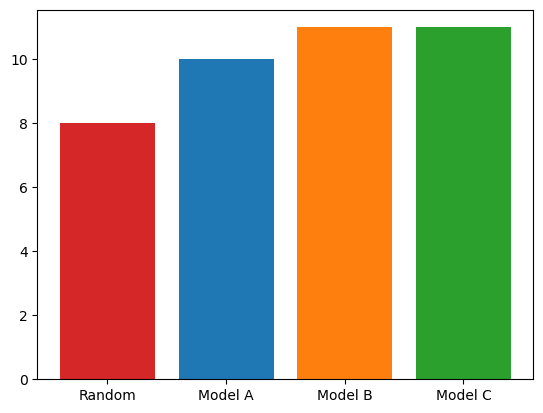

In [58]:
flattened_random_sampling = torch.cat([torch.tensor(samples.values, dtype=torch.float32) for samples in random_sampling]).reshape(-1, 1)

idsA = (train_yA > 0.9).nonzero(as_tuple=True)[0].tolist()
idsB = (train_yB > 0.9).nonzero(as_tuple=True)[0].tolist()
idsC = (train_yC > 0.9).nonzero(as_tuple=True)[0].tolist()
ids_random = (flattened_random_sampling  > 0.9).nonzero(as_tuple=True)[0].tolist()

compare = [ids_random,idsA,idsB,idsC] 

plt.bar(['Random', 'Model A', 'Model B', 'Model C'], [len(ids_random), len(idsA), len(idsB), len(idsC)], color=['tab:red','tab:blue', 'tab:orange', 'tab:green'])